**Library Imports**

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import os
import seaborn as sns

from scipy.stats import zscore

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

from matplotlib import pyplot
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from IPython.display import display

from imblearn.over_sampling import SMOTE

import tensorflow as tf

Panda Preferences

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

Read CSV

In [3]:
df = pd.read_csv("../Datasets/2022_combined.csv")
display(df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,type
0,CyjkPY35EAAJZFi01,192.168.1.15,39222,192.168.1.5,80,tcp,-,0.000111,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000111,1,1,0,0,9020.008602,9020.008602,18040.017204,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,110.864639,1.108646e+02,1.108646e+02,1.108646e+02,0.000000e+00,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.864639,1.108646e+02,1.108646e+02,1.108646e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64240,0,64240,0,http_flood
1,CBL1gm4jBAqsjSNhda,192.168.1.15,39302,192.168.1.5,80,tcp,-,3.1e-05,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000031,1,1,0,0,32263.876923,32263.876923,64527.753846,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,30.994415,3.099442e+01,3.099442e+01,3.099442e+01,0.000000e+00,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.994415,3.099442e+01,3.099442e+01,3.099442e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64240,0,64240,0,http_flood
2,Cmj0NZ62rJ2OIpfSh,192.168.1.15,39316,192.168.1.5,80,tcp,-,9.1e-05,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000091,1,1,0,0,10979.853403,10979.853403,21959.706806,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,91.075897,9.107590e+01,9.107590e+01,9.107590e+01,0.000000e+00,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.075897,9.107590e+01,9.107590e+01,9.107590e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64240,0,64240,0,http_flood
3,Ce9Qki4sd0QxGegSCb,192.168.1.15,39370,192.168.1.5,80,tcp,-,3.2e-05,0,0,REJ,-,-,0,Sr,1,60,1,40,-,0.000032,1,1,0,0,31300.776119,31300.776119,62601.552239,1.000000,40,40,40,20,20,20,0,1,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,31.948090,3.194809e+01,3.194809e+01,3.194809

Fix Dataframe Mixed Types

In [4]:
# Remove rows with '-' character in columns 7, 8 and 9
cols_to_check = ['duration', 'orig_bytes', 'resp_bytes']
#cols_to_check = ['duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'history', 'flow_duration']

mask = df[cols_to_check].apply(lambda x: x.str.contains('-', na=False)).any(axis=1)
df = df[~mask]

# Replace comma with period as decimal separator

cols_to_float = ['duration']
df[cols_to_float] = df[cols_to_float].replace(',', '.', regex=True)

# Convert columns 7, 8, 9, and 17 to float and int data type
cols_to_int = ['orig_bytes', 'resp_bytes']

df[cols_to_float] = df[cols_to_float].astype(float)
df[cols_to_int] = df[cols_to_int].astype(int)

-----------------------------------------------------------

**DF Statistics and Info**

In [5]:
def display_information_dataframe(df_cop):
    summary_data = [{'Data Type': dtype, 'Column Name': col, 'Unique Values': df_cop[col].unique()} for col, dtype in df_cop.dtypes.iteritems()]
    summary_df = pd.DataFrame(summary_data)
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    return summary_df

In [6]:
display_information_dataframe(df)

,Data Type,Column Name,Unique Values
0,object,uid,"[CyjkPY35EAAJZFi01, CBL1gm4jBAqsjSNhda, Cmj0NZ..."
1,object,id.orig_h,"[192.168.1.15, 192.168.1.12, 192.168.1.10, 192..."
2,int64,id.orig_p,"[39222, 39302, 39316, 39370, 39414, 39510, 395..."
3,object,id.resp_h,"[192.168.1.5, 35.224.170.84, 192.168.1.1, 34.1..."
4,int64,id.resp_p,"[80, 1880, 5683, 1883, 53, 123, 53197, 60635, ..."
5,object,proto,"[tcp, udp, icmp]"
6,object,service,"[-, http, dns, ntp, ssl, dhcp]"
7,float64,duration,"[0.00011100000000000001, 3.1e-05, 9.1e-05, 3.2..."
8,int64,orig_bytes,"[0, 353, 181, 182, 2655, 4150, 4100, 470, 705,..."
9,int64,resp_bytes,"[0, 294, 2460, 2680, 2144, 95, 108, 148, 48, 1..."


--------------------------------------------

**Pre-processing and Data Encoding**

Split History

In [7]:
def count_letters(string, is_upper):
    count = 0
    for c in string:
        if is_upper and c.isupper():
            count += 1
        elif not is_upper and c.islower():
            count += 1
    return count

In [8]:
df['history_originator'] = df['history'].apply(lambda x: count_letters(x, True))
df['history_responder'] = df['history'].apply(lambda x: count_letters(x, False))

Delete Insignificant Columns from the Dataframe

In [9]:
def delete_columns(df, cols):
    for col in cols:
        df.drop(col, axis = 1, inplace = True)
        print(f'[REMOVED] {col}')
    
    return df

In [10]:
cols_to_del = [
    'uid',
    'id.orig_h',
    'id.orig_p',
    'id.resp_h',
    'id.resp_p',
    'active.min',
    'service',
    'history',
    'local_orig',
    'local_resp',
    'tunnel_parents',
    'fwd_URG_flag_count',
    'bwd_URG_flag_count',
    'flow_CWR_flag_count',
    'flow_ECE_flag_count',
    ]

df = delete_columns(df,cols_to_del)

[REMOVED] uid
[REMOVED] id.orig_h
[REMOVED] id.orig_p
[REMOVED] id.resp_h
[REMOVED] id.resp_p
[REMOVED] active.min
[REMOVED] service
[REMOVED] history
[REMOVED] local_orig
[REMOVED] local_resp
[REMOVED] tunnel_parents
[REMOVED] fwd_URG_flag_count
[REMOVED] bwd_URG_flag_count
[REMOVED] flow_CWR_flag_count
[REMOVED] flow_ECE_flag_count


Split

In [11]:
#preparring to apply smoteNC
df_train=df.sample(frac=0.75,random_state=42)
df_test=df.drop(df_train.index)

SMOTE

In [12]:
def apply_smotenc_bigdata(df: pd.DataFrame, label: str, categorical_indices: list = [], random_state: int = 0) -> pd.DataFrame:
    """
    This function applies the SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous features)
    algorithm to oversample a dataset with imbalanced classes. SMOTENC is a variation of the SMOTE algorithm that can
    handle datasets with both numerical and categorical features. This function is doing a cicle to oversample the data 
    with the minor class. Because otherwise the SMOTENC algorithm is not working with big data.
    
    Parameters:
        - df (pd.DataFrame): a Pandas DataFrame containing the dataset to be oversampled.
        - label (str): the name of the column containing the target variable.
        - categorical_indices (list): a list containing the indices of the columns in `df` that contain categorical
                                      variables. Default: [].
        - random_state (int): the random seed to use for reproducibility. Default: 0.
    Returns:
        - df_smote (pd.DataFrame): a new Pandas DataFrame containing the original data plus the synthetic minority class
                                   samples generated by the SMOTENC algorithm.
    """
    from imblearn.over_sampling import SMOTENC
    # Make a copy of the input dataframe and separate the target variable column
    X_resampled = df.copy()
    X_resampled = X_resampled.drop(columns=[label])
    y_resampled = df[label].copy()
    
    # Apply the SMOTENC algorithm to oversample the dataset
    print(f"Started SMOTENC; size of df - {df.size} ")
    
    # Apply the SMOTENC algorithm to oversample the dataset
    smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=random_state,sampling_strategy="minority")

    for labels in np.unique(y_resampled):
        X_resampled, y_resampled = smote_nc.fit_resample(X_resampled, y_resampled)
    
    df_smote = pd.DataFrame(X_resampled, columns=X_resampled.columns)
    df_smote[label]=y_resampled
    
    # Print the size of the original and oversampled datasets, and return the oversampled dataset
    print(f"finished SMOTENC; size of df - {df_smote.size}")
    return df_smote

In [13]:
cols_to_encode = [
    'proto',
    'conn_state',
    'fwd_header_size_min',
    'fwd_header_size_max',
    'bwd_header_size_min',
    'bwd_header_size_max',
    'flow_FIN_flag_count',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'history_originator',
    'history_responder',
]

#get indexes
featuresFromStart = [ col for col in df_train.columns if col not in ["type"]]
catIndexs = []
for cc in cols_to_encode:
    catIndexs.append(featuresFromStart.index(cc))

print("---------------")
print(df_train.shape)
df_train = apply_smotenc_bigdata(df= df_train, label= "type", categorical_indices= catIndexs, random_state= 42)
print(df_train.shape)
print("---------------")

---------------
(353347, 88)
Started SMOTENC; size of df - 31094536 
finished SMOTENC; size of df - 73359440
(833630, 88)
---------------


In [14]:
#rejoin arrays to get them in one again after SMOTENC and saving the key so we can split it again
df = pd.concat([df_train,df_test],keys=[0,1])

One Hot Encoding

In [15]:
def one_hot_encoding(df, columns):
    for col in columns:
        print(f'[ONE HOT ENCONDING] {col}')
        df = pd.get_dummies(df, columns=[col], prefix=col)
    return df

In [16]:
cols_to_encode = [
    'proto',
    'conn_state',
    'fwd_header_size_min',
    'fwd_header_size_max',
    'bwd_header_size_min',
    'bwd_header_size_max',
    'flow_FIN_flag_count',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'history_originator',
    'history_responder',
]

df = one_hot_encoding(df,cols_to_encode)

[ONE HOT ENCONDING] proto
[ONE HOT ENCONDING] conn_state
[ONE HOT ENCONDING] fwd_header_size_min
[ONE HOT ENCONDING] fwd_header_size_max
[ONE HOT ENCONDING] bwd_header_size_min
[ONE HOT ENCONDING] bwd_header_size_max
[ONE HOT ENCONDING] flow_FIN_flag_count
[ONE HOT ENCONDING] flow_SYN_flag_count
[ONE HOT ENCONDING] flow_RST_flag_count
[ONE HOT ENCONDING] history_originator
[ONE HOT ENCONDING] history_responder


In [17]:
def missed_bytes(missed_bytes):
    if missed_bytes < 1:
        return 0
    else:
        return 1

In [18]:
df['missed_bytes'] = df.apply(lambda row: missed_bytes(row['missed_bytes']), axis=1)

Remove Outliers

In [19]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print(f'[REMOVE OUTLIERS] {col}')
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [20]:
outliers = [
    'orig_pkts',
    'resp_pkts',
    'orig_ip_bytes',
    'resp_ip_bytes',
]

df = remove_outliers(df, outliers, 3)

[REMOVE OUTLIERS] orig_pkts
[REMOVE OUTLIERS] resp_pkts
[REMOVE OUTLIERS] orig_ip_bytes
[REMOVE OUTLIERS] resp_ip_bytes


Normalize, Z-score

In [21]:
def zscore_normalization(df, cols):
    # Standardize the selected columns
    for col in cols:
        if col not in df.columns:
            print(f"[WARNING] {col} not found in DataFrame.")
            continue
        df[col] = zscore(df[col])
    
    print("[DONE] Z-score Normalization")
    print("[INFO] Current Fields in the DataFrame:")
    return df

In [22]:
cols_to_zscore = [
    'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
    'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
    'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 
    'bwd_header_size_tot', 'fwd_PSH_flag_count',
    'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_pkts_payload.min',
    'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
    'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
    'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
    'flow_pkts_payload.min', 'flow_pkts_payload.max', 'flow_pkts_payload.tot',
    'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd_iat.min',
    'fwd_iat.max', 'fwd_iat.tot', 'fwd_iat.avg', 'fwd_iat.std',
    'bwd_iat.min', 'bwd_iat.max', 'bwd_iat.tot', 'bwd_iat.avg', 'bwd_iat.std',
    'flow_iat.min', 'flow_iat.max', 'flow_iat.tot', 'flow_iat.avg',
    'flow_iat.std', 'payload_bytes_per_second', 'fwd_subflow_pkts',
    'bwd_subflow_pkts', 'fwd_subflow_bytes', 'bwd_subflow_bytes',
    'fwd_bulk_bytes', 'bwd_bulk_bytes', 'fwd_bulk_packets', 'bwd_bulk_packets',
    'fwd_bulk_rate', 'bwd_bulk_rate', 'active.max', 'active.tot',
    'active.avg', 'active.std', 'idle.min', 'idle.max', 'idle.tot',
    'idle.avg', 'idle.std', 'fwd_init_window_size', 'bwd_init_window_size',
    'fwd_last_window_size', 'bwd_last_window_size', 'duration', 'orig_bytes',
    'resp_bytes', 'orig_pkts', 'resp_pkts', 'resp_ip_bytes', 'orig_ip_bytes',
]

df = zscore_normalization(df, cols_to_zscore)

[DONE] Z-score Normalization
[INFO] Current Fields in the DataFrame:


---------------------------------------

**Create Model & Train Model**

In [23]:
df.groupby('type')['type'].count()

type
arp_spoofing            83756
http_botnet             59771
http_flood             107990
http_flood_node_red     96980
icmp_flood              90877
mqtt_flood             107325
normal                  85637
port_scanning           84759
tcp_flood               89894
udp_flood              111299
Name: type, dtype: int64

In [25]:
# Select rows with level 0 of index (i.e., training data)
df_train_smote = df.loc[0]

le = LabelEncoder()
le.fit(df_train_smote["type"].values)

x_columns = df_train_smote.columns.drop('type')

x_smote = df_train_smote[x_columns].values
y_smote = df_train_smote["type"].values
y_smote = le.transform(y_smote)

# Split into training and testing sets
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(x_smote, y_smote, test_size=0.25, random_state=42, stratify=y_smote)

In [26]:
# Select rows with level 0 of index (i.e., training data)
df_test = df.loc[1]

le = LabelEncoder()
le.fit(df_test["type"].values)

x_columns = df_test.columns.drop('type')

x = df[x_columns].values
y = df["type"].values
y = le.transform(y)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [27]:
x_train_smote.shape,y_train_smote.shape

((601791, 168), (601791,))

In [28]:
x_test.shape,y_test.shape

((229572, 168), (229572,))

In [29]:
# Define the model
model = Sequential()
model.add(Dense(512, input_dim=x_train_smote.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.5,mode="min",patience=10,verbose=1,min_lr=1e-7)
checkpoint = ModelCheckpoint('best_model_multiclass.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(x_train_smote, y_train_smote, validation_data=(x_test_smote, y_test_smote), epochs=300, batch_size=512, callbacks=[monitor, checkpoint])

Train on 601791 samples, validate on 200597 samples
Epoch 1/300
601791/601791 [==============================] - 4s 7us/sample - loss: 1.3841 - accuracy: 0.5005 - val_loss: 0.5426 - val_accuracy: 0.7997
Epoch 2/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.7601 - accuracy: 0.6917 - val_loss: 0.4507 - val_accuracy: 0.8081
Epoch 3/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.6263 - accuracy: 0.7395 - val_loss: 0.4190 - val_accuracy: 0.8130
Epoch 4/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.5667 - accuracy: 0.7619 - val_loss: 0.4068 - val_accuracy: 0.8231
Epoch 5/300
601791/601791 [==============================] - 3s 6us/sample - loss: 0.5322 - accuracy: 0.7744 - val_loss: 0.3972 - val_accuracy: 0.8238
Epoch 6/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.5112 - accuracy: 0.7816 - val_loss: 0.3909 - val_accuracy: 0.8245
Epoch 7/300
601791/601791 [===============

601791/601791 [==============================] - 4s 6us/sample - loss: 0.3985 - accuracy: 0.8257 - val_loss: 0.3596 - val_accuracy: 0.8330
Epoch 55/300
601791/601791 [==============================] - 5s 8us/sample - loss: 0.3981 - accuracy: 0.8257 - val_loss: 0.3593 - val_accuracy: 0.8329
Epoch 56/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3977 - accuracy: 0.8252 - val_loss: 0.3583 - val_accuracy: 0.8333
Epoch 57/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3976 - accuracy: 0.8257 - val_loss: 0.3587 - val_accuracy: 0.8331
Epoch 58/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3960 - accuracy: 0.8263 - val_loss: 0.3581 - val_accuracy: 0.8330
Epoch 59/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3968 - accuracy: 0.8261 - val_loss: 0.3586 - val_accuracy: 0.8333
Epoch 60/300
601791/601791 [==============================] - 5s 8us/sample - loss: 0.3963 - accuracy

Epoch 108/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3847 - accuracy: 0.8299 - val_loss: 0.3532 - val_accuracy: 0.8347
Epoch 109/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3852 - accuracy: 0.8297 - val_loss: 0.3528 - val_accuracy: 0.8360
Epoch 110/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3844 - accuracy: 0.8302 - val_loss: 0.3534 - val_accuracy: 0.8345
Epoch 111/300
601791/601791 [==============================] - 5s 8us/sample - loss: 0.3846 - accuracy: 0.8302 - val_loss: 0.3546 - val_accuracy: 0.8340
Epoch 112/300
601791/601791 [==============================] - 4s 7us/sample - loss: 0.3838 - accuracy: 0.8305 - val_loss: 0.3502 - val_accuracy: 0.8390
Epoch 113/300
601791/601791 [==============================] - 6s 10us/sample - loss: 0.3844 - accuracy: 0.8300 - val_loss: 0.3518 - val_accuracy: 0.8377
Epoch 114/300
601791/601791 [==============================] - 7s 11us/sample - l

601791/601791 [==============================] - 5s 9us/sample - loss: 0.3769 - accuracy: 0.8335 - val_loss: 0.3465 - val_accuracy: 0.8402
Epoch 161/300
601791/601791 [==============================] - 6s 10us/sample - loss: 0.3764 - accuracy: 0.8337 - val_loss: 0.3458 - val_accuracy: 0.8402
Epoch 162/300
601791/601791 [==============================] - 6s 10us/sample - loss: 0.3759 - accuracy: 0.8335 - val_loss: 0.3464 - val_accuracy: 0.8403
Epoch 163/300
601791/601791 [==============================] - 5s 9us/sample - loss: 0.3764 - accuracy: 0.8336 - val_loss: 0.3469 - val_accuracy: 0.8402
Epoch 164/300
601791/601791 [==============================] - 5s 9us/sample - loss: 0.3772 - accuracy: 0.8328 - val_loss: 0.3473 - val_accuracy: 0.8402
Epoch 165/300
601791/601791 [==============================] - 5s 9us/sample - loss: 0.3766 - accuracy: 0.8335 - val_loss: 0.3483 - val_accuracy: 0.8402
Epoch 166/300
601791/601791 [==============================] - 5s 9us/sample - loss: 0.3755 - 

601791/601791 [==============================] - 4s 6us/sample - loss: 0.3721 - accuracy: 0.8356 - val_loss: 0.3440 - val_accuracy: 0.8403
Epoch 214/300
601791/601791 [==============================] - 3s 6us/sample - loss: 0.3716 - accuracy: 0.8359 - val_loss: 0.3437 - val_accuracy: 0.8405
Epoch 215/300
601791/601791 [==============================] - 3s 6us/sample - loss: 0.3712 - accuracy: 0.8359 - val_loss: 0.3445 - val_accuracy: 0.8403
Epoch 216/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.3711 - accuracy: 0.8358 - val_loss: 0.3435 - val_accuracy: 0.8404
Epoch 217/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.3713 - accuracy: 0.8360 - val_loss: 0.3436 - val_accuracy: 0.8404
Epoch 218/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.3716 - accuracy: 0.8355 - val_loss: 0.3448 - val_accuracy: 0.8403
Epoch 219/300
601791/601791 [==============================] - 3s 5us/sample - loss: 0.3723 - ac

601791/601791 [==============================] - 5s 8us/sample - loss: 0.3688 - accuracy: 0.8367 - val_loss: 0.3424 - val_accuracy: 0.8406
Epoch 265/300
601791/601791 [==============================] - 6s 9us/sample - loss: 0.3691 - accuracy: 0.8367 - val_loss: 0.3426 - val_accuracy: 0.8406
Epoch 266/300
601791/601791 [==============================] - 6s 10us/sample - loss: 0.3684 - accuracy: 0.8365 - val_loss: 0.3428 - val_accuracy: 0.8406
Epoch 267/300
601791/601791 [==============================] - 6s 10us/sample - loss: 0.3693 - accuracy: 0.8367 - val_loss: 0.3430 - val_accuracy: 0.8405
Epoch 268/300
601791/601791 [==============================] - 6s 10us/sample - loss: 0.3684 - accuracy: 0.8367 - val_loss: 0.3427 - val_accuracy: 0.8406
Epoch 269/300
600064/601791 [============================>.] - ETA: 0s - loss: 0.3685 - accuracy: 0.8368
Epoch 00269: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
601791/601791 [==============================] - 6s 10us/samp

In [30]:
# Load the best-saved model
best_model = load_model('best_model_multiclass.h5')

# Evaluate the best-saved model
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = accuracy_score(y_test, y_pred_classes)
print('')
print('Test accuracy:', acc)


Test accuracy: 0.8377807398114753


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               86528     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

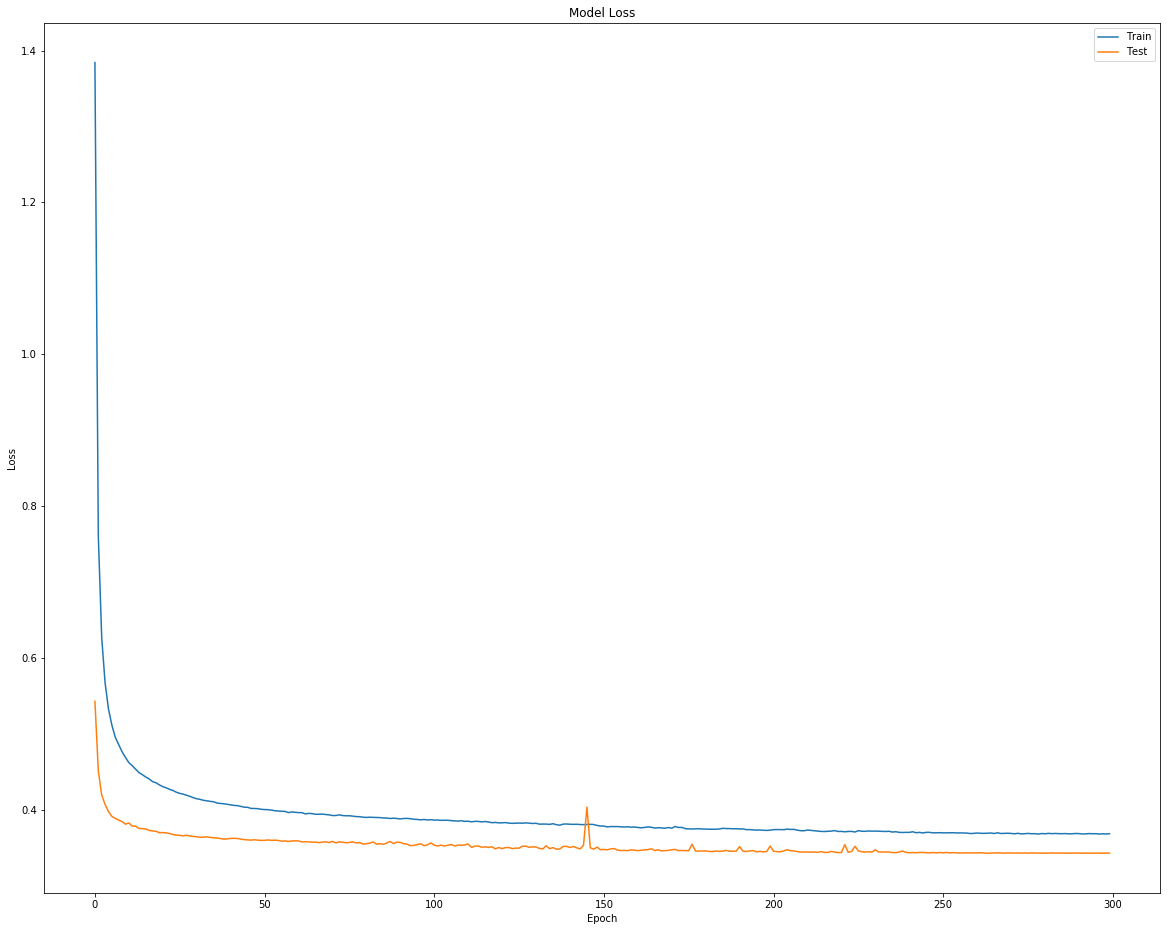

In [32]:
fig, ax = plt.subplots(figsize=(20, 16))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
pred = model.predict(x_test)

In [34]:
print(y_test.shape)  # should output (111923,)
print(pred.shape)    # should output (111923, num_classes)

(229572,)
(229572, 10)


In [35]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

def calculate_metrics(modelName, yTrue, yPred, average='binary'):
    """
    Calculate and print the performance metrics of a classification model.
    
    Parameters:
    modelName (str): The name of the classification model.
    yTrue (array-like): The true labels.
    yPred (array-like): The predicted labels.
    average (str or None, optional): The averaging method to use for multi-class classification. One of 
        {'micro', 'macro', 'weighted', 'binary'} or None (default: 'binary'). If None, only binary 
        classification metrics will be computed.
    
    Raises:
    ValueError: If `average` is not one of {'micro', 'macro', 'weighted', 'binary'} or None.
    
    """
    # Check if average parameter is valid
    if average != 'micro' and average != 'macro' and average != 'weighted' and average != 'binary' and average != None:
        print("Average must be one of this options: {‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} or None, default=’binary’")
        return
    
    # Prints the name of the model and calculate accuracy and precision
    print(f"--- Performance of {modelName} ---")
    acc = accuracy_score(y_true = yTrue, y_pred = yPred)
    precision = precision_score(y_true = yTrue, y_pred = yPred, average = average)
    print(f'Accuracy : {np.round(acc*100,2)}%\nPrecision: {np.round(precision*100,2)}%')
    
    # Calculates and print recall and F1-score
    f1 = f1_score(y_true = yTrue, y_pred = yPred, average = average)
    recall = recall_score(y_true = yTrue, y_pred = yPred, average = average)
    print(f'Recall: {np.round(recall*100,2)}%\nF1-score: {np.round(f1*100,2)}%')
    
    #auc_sklearn = roc_auc_score(y_true = yTrue, y_score = yPred, average = average)
    #print(f'Roc auc: {np.round(auc_sklearn*100,2)}%')
    
    # Calculates and prints balanced accuracy and classification report
    print(f"Balanced accuracy: {np.round(balanced_accuracy_score(yTrue, yPred)*100,2)}%")
    print(f"Classification report:\n{classification_report(yTrue, yPred)}")

In [36]:
pred_labels = np.argmax(pred, axis=1)

calculate_metrics("Neural Network", y_test, pred_labels, average='weighted')

--- Performance of Neural Network ---
Accuracy : 83.78%
Precision: 88.43%
Recall: 83.78%
F1-score: 81.97%
Balanced accuracy: 84.11%
Classification report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     20939
           1       1.00      1.00      1.00     14943
           2       0.66      1.00      0.80     26998
           3       1.00      0.48      0.65     24245
           4       1.00      1.00      1.00     22719
           5       0.99      0.68      0.81     26831
           6       1.00      0.28      0.44     21409
           7       0.75      0.98      0.85     21190
           8       0.72      1.00      0.84     22473
           9       1.00      1.00      1.00     27825

    accuracy                           0.84    229572
   macro avg       0.89      0.84      0.82    229572
weighted avg       0.88      0.84      0.82    229572



-------------------------------------

**Result Plots**

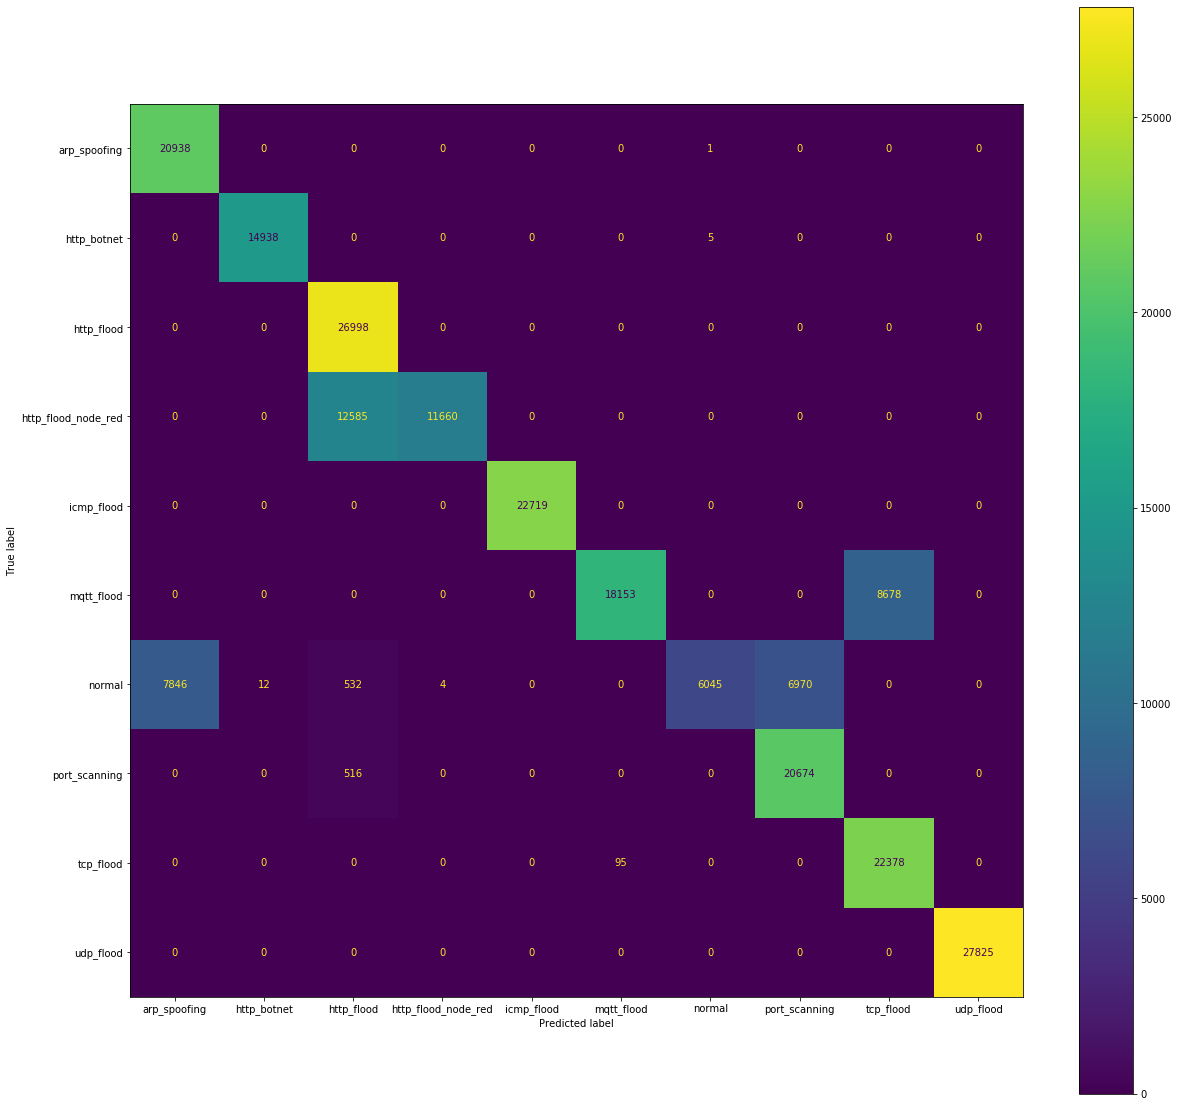

In [37]:
original_labels_list = le.classes_

# Compute confusion matrix
pred_labels = np.argmax(pred, axis=1)
cm = confusion_matrix(y_test, pred_labels)

# Display confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels= original_labels_list)
fig, ax = plt.subplots(figsize=(20, 20))
cmd.plot(ax=ax)

In [38]:
# Usage of ExtraTreesClassifier for feature selection
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

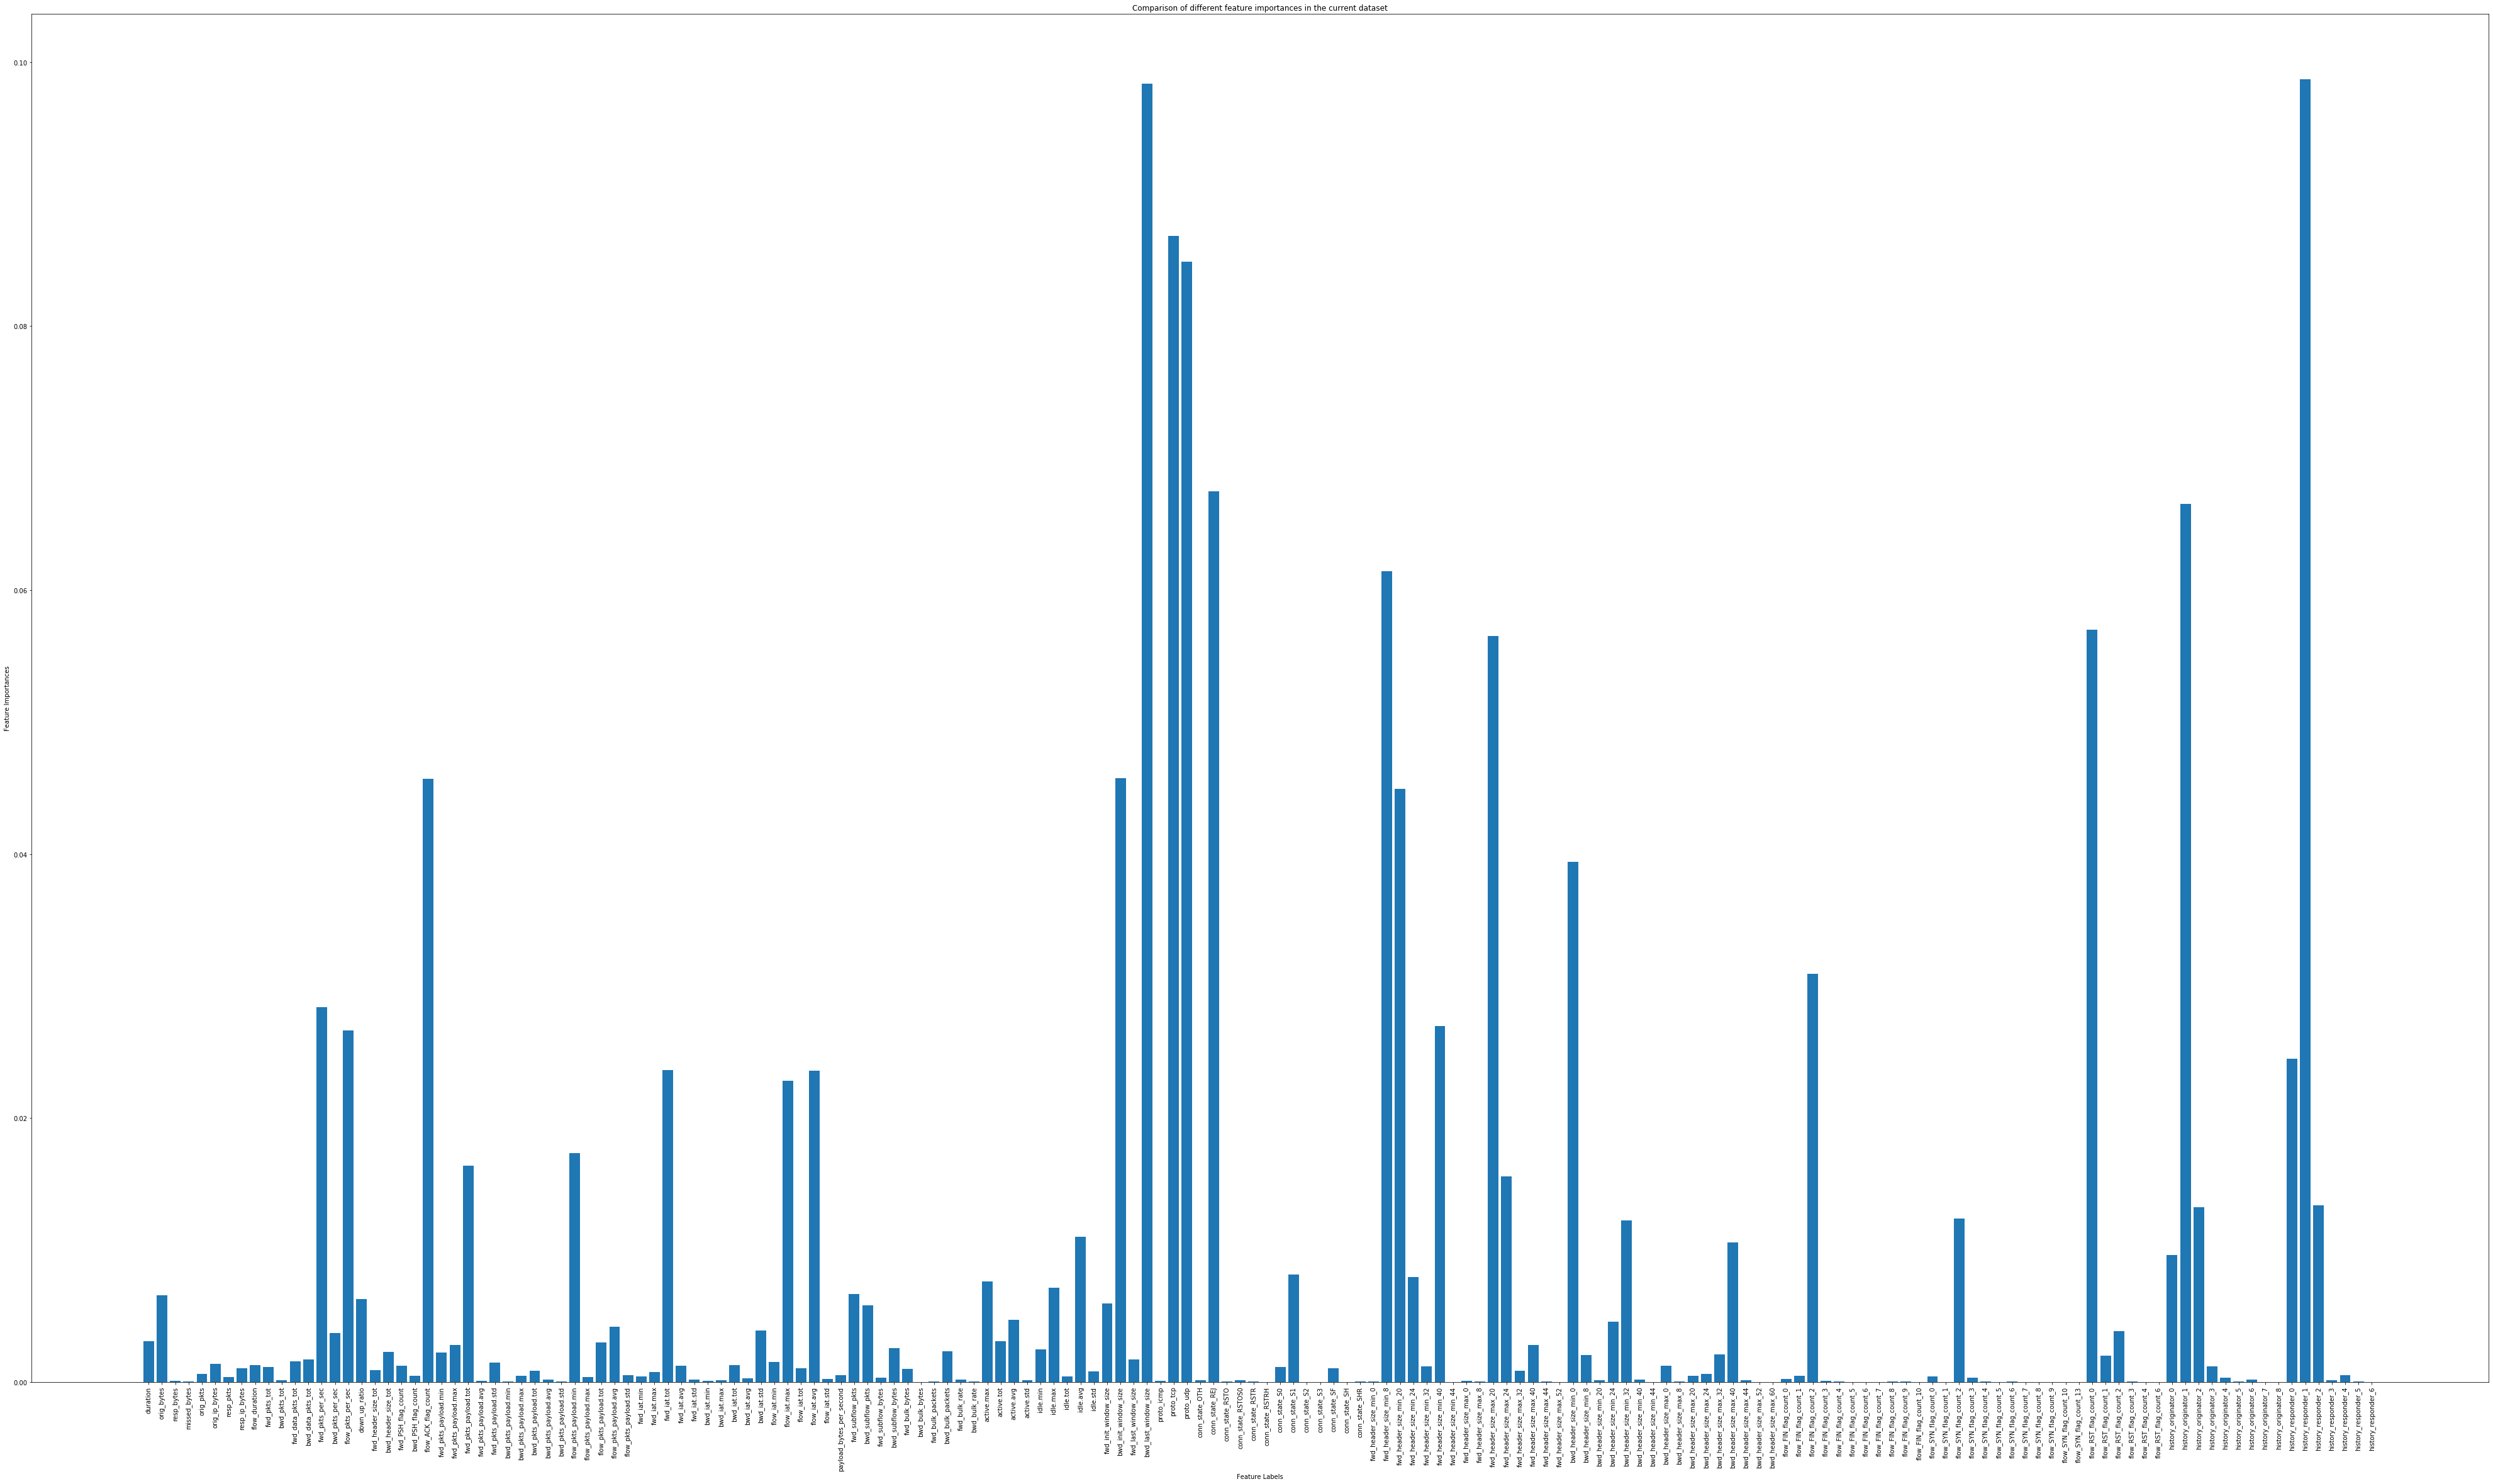

In [40]:
# Plor for the ExtraTreesClassifier output
plot.bar(x_columns, feature_importance_normalized)
plot.xlabel('Feature Labels')
plot.ylabel('Feature Importances')
plot.title('Comparison of different feature importances in the current dataset')
plot.xticks(rotation = 90)

# Plot size
plot.rcParams["figure.figsize"] = (70, 40)

plot.show()

## 